This notebook is to train a Named Entity Recognition (NER) model to detect the start of a conversation running on Google Colab.

# Load Packages

In [0]:
!pip install git+https://github.com/keras-team/keras.git -U
!pip install seqeval
!pip install tensorflow-gpu==2.0.0-alpha0
!pip install tensorflow-hub

In [0]:
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras.models import Model
from tensorflow.keras import Input
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import TimeDistributed, Dense, Embedding, Input, Dropout, LSTM, Bidirectional, Lambda
from tensorflow.keras.layers import concatenate
from seqeval.metrics import classification_report as classification_report_entity
from seqeval.metrics import precision_score, recall_score, f1_score
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard

## Make sure tensorflow 2.0 is installed

In [69]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

from datetime import datetime
from packaging import version

print("TensorFlow version: ", tf.__version__)
assert version.parse(tf.__version__).release[0] >= 2, \
    "This notebook requires TensorFlow 2.0 or above."

TensorFlow version:  2.0.0-alpha0


## Check available GPU

In [4]:
x = tf.random.uniform([3, 3])

print("Is there a GPU available: "),
print(tf.test.is_gpu_available())

print("Is the Tensor on GPU #0:  "),
print(x.device.endswith('GPU:0'))

print("Device name: {}".format((x.device)))

Is there a GPU available: 
True
Is the Tensor on GPU #0:  
True
Device name: /job:localhost/replica:0/task:0/device:GPU:0


# Prepare data

Fetch the dataset from Google drive and read as dataframe.

## Load dataset

In [5]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
loc = '/content/gdrive/My Drive/tf2.0/'

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os 

plt.style.use("ggplot")

data = pd.read_csv(os.path.join(loc, "iob-labeled-sent-final-060519-v2.csv"))
data = data.fillna(method="ffill")
data.head(15)

,Unnamed: 0,old_para_index,para_index,sent,label,split_tag
0,0,0,0,By Jane Austen,O,train
1,1,63,1,Chapter 1,O,train
2,2,64,2,"It is a truth universally acknowledged, that a...",O,train
3,3,65,3,However little known the feelings or views of ...,O,train
4,4,66,4,"""My dear Mr Bennet,""",B-START,train
5,5,66,4,"""have you heard that Netherfield Park is...",I-START,train
6,6,67,5,Mr Bennet replied that he had not.,O,train
7,7,68,6,"""But it is,""",B-OTHER,train
8,8,68,6,"""for Mrs Long has just been here, and she told...",I-OTHER,train
9,9,69,7,Mr Bennet made no answer.,O,train


In [9]:
data.shape

(2747, 6)

There are in total 2747 records in the dataset and our goal is to detect the Start of conversation, denoted by B-START and I-START. The approach is NER to find all START records and OTHER records with the dataset in IOB format.

In [10]:
tags = list(set(data["label"].values))
n_tags = len(tags); tags

['I-START', 'B-OTHER', 'O', 'I-OTHER', 'B-START']

## Group paragraphs and pad sentence

Next, we will group some paragraphs together so that the model can learn more contextual information to detect the start of conversation. In this notebook, we group 4 paragraphs into 1.

In [0]:
num_para_in_group = 4

data['grouped_para_index'] = data['para_index'].apply(lambda x: int(x/num_para_in_group+1))

In [0]:
# data['group_label'] = data['label'].apply(lambda x: x.split('-')[-1])

In [13]:
data.columns

Index(['Unnamed: 0', 'old_para_index', 'para_index', 'sent', 'label',
       'split_tag', 'grouped_para_index'],
      dtype='object')

In [0]:
for index, row in data.iterrows():
    if row['label'] == 'I-OTHER':
        if data.iloc[index-1, 4] != 'B-OTHER':
            print(index)
            print(data.iloc[index-1, 4])
            row['para_index_2'] = data.iloc[index-1, 0]


In [0]:
class paragraphGetter(object):

    def __init__(self, data):
        self.n_para = 1
        self.data = data
        self.empty = False
        agg_func = lambda s: [(w, p, t) for w, p, t in zip(s["sent"].values.tolist(),
                                                           s["split_tag"].values.tolist(),
                                                           s["label"].values.tolist())]
        self.grouped = self.data.groupby("grouped_para_index").apply(agg_func)
        print(self.grouped)
        self.paragraphs = [s for s in self.grouped]
    
    def get_next(self):
        try:
            s = self.grouped["grouped_paragraph: {}".format(self.n_para)]
            print(s)
            self.n_para += 1
            return s
        except:
            return None

In [0]:
getter = paragraphGetter(data)

In [0]:
paragraphs = getter.paragraphs

In [22]:
len(paragraphs)

530

After grouping, there are 530 data points in the dataset. Each groupped paragraph contains the multiple sentence and tag pairs.

In [23]:
print(paragraphs[0])

[('By Jane Austen', 'train', 'O'), ('Chapter 1', 'train', 'O'), ('It is a truth universally acknowledged, that a single man in possession of       a good fortune, must be in want of a wife.', 'train', 'O'), ('However little known the feelings or views of such a man may be on his       first entering a neighbourhood, this truth is so well fixed in the minds       of the surrounding families, that he is considered the rightful property       of some one or other of their daughters.', 'train', 'O')]


In [24]:
maxlen = max([len(s) for s in paragraphs])
print('Maximum sequence length:', maxlen)

Maximum sequence length: 11


Maximum sequence length is 11, so we set the max_len to be 11 for padding.

In [0]:
max_len = 11
tag2idx = {'B-OTHER': 4, 'B-START': 3, 'I-OTHER': 0, 'I-START': 1, 'O': 2}

In [26]:
X_ori = [[w[0] for w in s] for s in paragraphs]

X = []
for seq in X_ori:
    new_seq = []
    for i in range(max_len):
        try:
            new_seq.append(seq[i])
        except:
            new_seq.append("PAD")
    X.append(new_seq)
X[0]

['By Jane Austen',
 'Chapter 1',
 'It is a truth universally acknowledged, that a single man in possession of       a good fortune, must be in want of a wife.',
 'However little known the feelings or views of such a man may be on his       first entering a neighbourhood, this truth is so well fixed in the minds       of the surrounding families, that he is considered the rightful property       of some one or other of their daughters.',
 'PAD',
 'PAD',
 'PAD',
 'PAD',
 'PAD',
 'PAD',
 'PAD']

In [27]:
print(np.asarray(X).shape)

(530, 11)


## Bert sentence embedding

bert_embedding, an open-source package is used to generate the sentence embedding

In [0]:
!pip install bert_embedding

The average of all words' embedding in a sentence is used as this sentence's embedding

In [0]:
from bert_embedding import BertEmbedding
bert_embedding = BertEmbedding()

def bertSentenceEmbedding(x):
  embeddings = []
  count = 0
  for para in x:
    para_all_embed = np.asarray(bert_embedding(para))[:,1]
  
    para_embed = []
    for embed in np.asarray(para_all_embed):
      count = 0
      all_embed = [0]*768
      for word_embed in embed:
        count += 1
        all_embed = all_embed + word_embed
      # average of word embedding as sentence embedding
      sent_embed = all_embed/count
      para_embed.append(sent_embed)
      
    embeddings.append(para_embed)
  return embeddings

The embedding generation takes long time, so we generate once and save it for future use.

In [0]:
X_embed = np.load(os.path.join(loc, "v3-g4-b4/X_g_embedding_4.npy"))

In [31]:
print(np.asarray(X_embed).shape)

(530, 11, 768)


## Prepare train, test, validation dataset

In [32]:
y = [[tag2idx[w[2]] for w in s] for s in paragraphs]

y = pad_sequences(maxlen=max_len, sequences=y, padding="post", value=tag2idx["O"])
y[0]

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], dtype=int32)

In [33]:
train_index = set(data[data['split_tag']=='train']['grouped_para_index'].values)
valid_index = set(data[data['split_tag']=='validation']['grouped_para_index'].values)
test_index = set(data[data['split_tag']=='test']['grouped_para_index'].values)

X_tr = [np.asarray(X_embed)[i-1] for i in train_index]
X_val = [np.asarray(X_embed)[i-1] for i in valid_index]
X_te = [np.asarray(X_embed)[i-1] for i in test_index]

y_tr = np.asarray([y[i-1] for i in train_index])
y_val = np.asarray([y[i-1] for i in valid_index])
y_te = np.asarray([y[i-1] for i in test_index])

print("no. of paragraphs in training: ", len(X_tr))
print("no. of paragraphs in validation: ", len(X_val))
print("no. of paragraphs in testing: ", len(X_te))

no. of paragraphs in training:  426
no. of paragraphs in validation:  52
no. of paragraphs in testing:  54


In [34]:
batch_size = 4

X_tr = X_tr[0:int(np.floor(len(X_tr)/batch_size)*batch_size)]
X_val = X_val[0:int(np.floor(len(X_val)/batch_size)*batch_size)]
y_tr = y_tr[0:int(np.floor(len(y_tr)/batch_size)*batch_size)]
y_val = y_val[0:int(np.floor(len(y_val)/batch_size)*batch_size)]
print("training input: ", len(X_tr), "validation input: ", len(X_val))
y_tr = y_tr.reshape(y_tr.shape[0], y_tr.shape[1], 1)
y_val = y_val.reshape(y_val.shape[0], y_val.shape[1], 1)

training input:  424 validation input:  52


In [35]:
print("training input: ", len(X_tr), "validation input: ", len(X_val))
y_tr = y_tr.reshape(y_tr.shape[0], y_tr.shape[1], 1)
y_val = y_val.reshape(y_val.shape[0], y_val.shape[1], 1)

training input:  424 validation input:  52


# Build model

In [0]:
VERSION = 4
EPOCHS = 30

## Setup TensorBoard for Colab

In [0]:
# Clear any logs from previous runs
!rm -rf ./logs/ 

In [0]:
!wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
!unzip ngrok-stable-linux-amd64.zip

In [0]:
LOG_DIR = './log'
get_ipython().system_raw(
    'tensorboard --logdir {} --host 0.0.0.0 --port 6006 &'
    .format(LOG_DIR)
)

In [0]:
get_ipython().system_raw('./ngrok http 6006 &')

In [41]:
! curl -s http://localhost:4040/api/tunnels | python3 -c \
    "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"

https://21ab9294.ngrok.io


## Construct model

In [0]:
es = EarlyStopping(monitor='val_loss', min_delta=0, patience=4)
model_loc = loc + "v3-g4-b4/"

filepath = os.path.join(loc, "new_fiction-bert-iob-epochs-{}-b{}-v{}.hdf5".format(EPOCHS, batch_size, VERSION))
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False,
                             mode='auto', period=1)

tensorboard_callback = TensorBoard(log_dir='./log')

callbacks_list = [es, checkpoint, tensorboard_callback]

In [44]:
def build_model():
    input_text = Input(shape=(max_len, 768))
    x = Bidirectional(LSTM(units=512, return_sequences=True,
                           recurrent_dropout=0.2, dropout=0.2))(input_text)
    x_rnn = Bidirectional(LSTM(units=512, return_sequences=True,
                               recurrent_dropout=0.2, dropout=0.2))(x)
    x = concatenate([x, x_rnn])  # residual connection to the first biLSTMSS
    out = TimeDistributed(Dense(n_tags, activation="softmax"))(x)

    model = Model(input_text, out)
    model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=['sparse_categorical_accuracy'])
    model.summary()

    return model
  
model = build_model()

W0506 12:58:50.545105 140302138619776 tf_logging.py:161] <tensorflow.python.keras.layers.recurrent.UnifiedLSTM object at 0x7f99e6115e10>: Note that this layer is not optimized for performance. Please use tf.keras.layers.CuDNNLSTM for better performance on GPU.
W0506 12:58:50.554162 140302138619776 tf_logging.py:161] <tensorflow.python.keras.layers.recurrent.UnifiedLSTM object at 0x7f99e60f1a58>: Note that this layer is not optimized for performance. Please use tf.keras.layers.CuDNNLSTM for better performance on GPU.
W0506 12:58:50.909147 140302138619776 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/backend.py:4081: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
W0506 12:58:51.750241 140302138619776 tf_logging.py:161] <tensorflow.python.keras.layers.recurrent

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 11, 768)]    0                                            
__________________________________________________________________________________________________
bidirectional (Bidirectional)   (None, 11, 1024)     5246976     input_1[0][0]                    
__________________________________________________________________________________________________
bidirectional_1 (Bidirectional) (None, 11, 1024)     6295552     bidirectional[0][0]              
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 11, 2048)     0           bidirectional[0][0]              
                                                                 bidirectional_1[0][0]        

# Fit model

## Model fitting

In [45]:
history = model.fit(np.array(X_tr), y_tr, validation_data=(np.array(X_val), y_val),
                    batch_size=batch_size, epochs=EPOCHS, verbose=1, callbacks=callbacks_list)

Train on 424 samples, validate on 52 samples
Epoch 1/30
  4/424 [..............................] - ETA: 7:15 - loss: 1.6673 - sparse_categorical_accuracy: 0.0227

W0506 12:59:06.735549 140302138619776 callbacks.py:236] Method (on_train_batch_end) is slow compared to the batch update (1.021728). Check your callbacks.


420/424 [============================>.] - ETA: 0s - loss: 0.3669 - sparse_categorical_accuracy: 0.8652
Epoch 00001: val_loss improved from inf to 0.14319, saving model to /content/gdrive/My Drive/tf2.0/new_fiction-bert-iob-epochs-30-b4-v4.hdf5
424/424 [==============================] - 35s 84ms/sample - loss: 0.3661 - sparse_categorical_accuracy: 0.8656 - val_loss: 0.1432 - val_sparse_categorical_accuracy: 0.9371
Epoch 2/30
420/424 [============================>.] - ETA: 0s - loss: 0.1344 - sparse_categorical_accuracy: 0.9465
Epoch 00002: val_loss improved from 0.14319 to 0.12333, saving model to /content/gdrive/My Drive/tf2.0/new_fiction-bert-iob-epochs-30-b4-v4.hdf5
424/424 [==============================] - 32s 75ms/sample - loss: 0.1344 - sparse_categorical_accuracy: 0.9464 - val_loss: 0.1233 - val_sparse_categorical_accuracy: 0.9493
Epoch 3/30
420/424 [============================>.] - ETA: 0s - loss: 0.0881 - sparse_categorical_accuracy: 0.9662
Epoch 00003: val_loss improved fro

In [0]:
import time

timestr = time.strftime("%m%d_%H%M")
model_name = "new_fiction_lstm_bert_v4_" + timestr + "_epoch" + str(EPOCHS) + '_b'+str(batch_size) +  '_v' + str(VERSION) + ".h5"
model_name_path = os.path.join(loc, "v3-g4-b4/" + model_name)
model.save(model_name_path)

## Plot loss curves

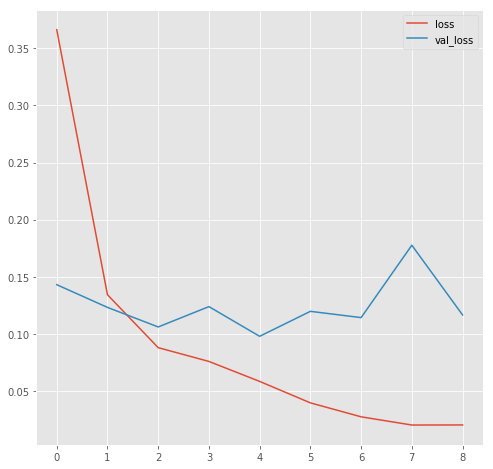

In [48]:
import pandas as pd
import matplotlib.pyplot as plt

hist = pd.DataFrame(history.history)

plt.style.use("ggplot")
plt.figure(figsize=(8, 8))
plt.plot(hist["loss"])
plt.plot(hist["val_loss"])
plt.legend()
plt.show()

# Model evaluation

We will evaluate model performance on validation and testing set.

## Label distribution

In [49]:
from seqeval.metrics import precision_score, recall_score, f1_score, classification_report

category_count = {'B-START':0, 'I-START':0, 'B-OTHER':0, 'I-OTHER':0, 'O':0}
total_count = 0

for sentence in paragraphs:
    for word in sentence:
        if word[2] in category_count.keys():
            category_count[word[2]] += 1
            total_count += 1

for category, count in category_count.items():
    print("{}: {}%".format(category.replace("\n", ""), round((count / total_count) * 100, 2)))


B-START: 8.34%
I-START: 4.37%
B-OTHER: 39.06%
I-OTHER: 11.58%
O: 36.66%


Define functions for evaluation

In [0]:
def pred2label(pred):
    out = []
    for pred_i in pred:
        out_i = []
        for p in pred_i:
            out_i.append(idx2tag[p].replace("PAD", "O"))
        out.append(out_i)
    return out


def y2label(y):
    out = []
    for y_i in y:
        out_i = []
        for p in y_i:
            for p_i in p:
                out_i.append(idx2tag[p_i].replace("PAD", "O"))
        out.append(out_i)
    return out

In [0]:
def evaluate_performance(X, y):
    pred_num = model.predict(np.array(X))
    pred = np.argmax(pred_num, axis=-1)
    pred_labels = pred2label(pred)
    labels = y2label(y)
    print(classification_report(labels, pred_labels))
    return pred

In [0]:
idx2tag = {v: k for k, v in tag2idx.items()}

Print classification report for validation set using seqeval package.

In [53]:
validation_performance = evaluate_performance(X_val, y_val)

           precision    recall  f1-score   support

    OTHER       0.90      0.94      0.92       109
    START       0.56      0.50      0.53        18

micro avg       0.86      0.87      0.87       127
macro avg       0.85      0.87      0.86       127



## Evaluation on test dataset

### Entity level classification report

In [54]:
np.array(X_te).shape

(54, 11, 768)

In [0]:
y_test = y_te
X_test = X_te
pred_num = model.predict(np.array(X_test))
pred = np.argmax(pred_num, axis=-1)
pred_labels = pred2label(pred)
y_labels = pred2label(y_test)

In [56]:
print(classification_report(y_labels, pred_labels))

           precision    recall  f1-score   support

    START       0.59      0.70      0.64        27
    OTHER       0.87      0.83      0.85       104

micro avg       0.80      0.80      0.80       131
macro avg       0.81      0.80      0.81       131



###  Label level classification report

In [0]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.savefig(os.path.join(loc, "bert_lstm_evaluation_model_v4_eva_test_conf.jpg"))
    plt.show()

In [0]:
label_pred = []
idx_pred = []

for sentence in pred:
    for element in sentence:
        idx_pred.append(element)
        label_pred.append(idx2tag[element])

label_correct = []
idx_correct = []
for sentence in y_test:
    for element in sentence:
        idx_correct.append(element)
        label_correct.append(idx2tag[element])

In [59]:
idx2tag

{0: 'I-OTHER', 1: 'I-START', 2: 'O', 3: 'B-START', 4: 'B-OTHER'}

In [0]:
from sklearn.metrics import confusion_matrix
cm_with_o = confusion_matrix(label_correct, label_pred)

In [61]:
df = pd.DataFrame(cm_with_o)
df_wo_o = df.iloc[:-1, :-1]
cm = df_wo_o.as_matrix()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  This is separate from the ipykernel package so we can avoid doing imports until


In [0]:
labels = list(idx2tag.values())
labels.remove('O')

In [63]:
labels_sorted = sorted(labels)
labels_sorted

['B-OTHER', 'B-START', 'I-OTHER', 'I-START']

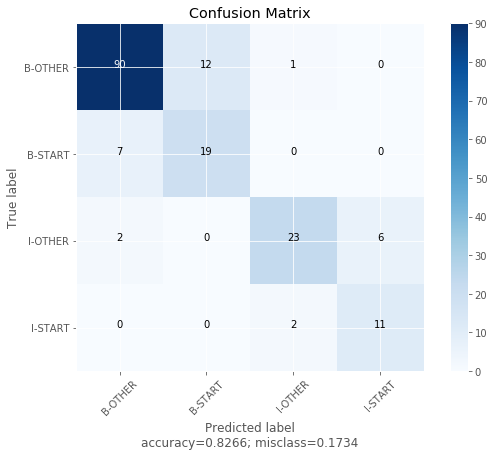

In [64]:
plot_confusion_matrix(cm           = cm,
                      normalize    = False,
                      target_names = labels_sorted,
                      title        = "Confusion Matrix")

In [0]:
# Clear any logs from previous runs
!rm -rf ./logs/ 

In [66]:
from sklearn.metrics import classification_report as classification_report_all

print(classification_report_all(label_correct, label_pred,
                                labels=labels_sorted,
                                digits=3))

              precision    recall  f1-score   support

     B-OTHER      0.909     0.865     0.887       104
     B-START      0.613     0.704     0.655        27
     I-OTHER      0.885     0.742     0.807        31
     I-START      0.647     0.846     0.733        13

   micro avg      0.827     0.817     0.822       175
   macro avg      0.763     0.789     0.771       175
weighted avg      0.840     0.817     0.825       175



In [67]:
from tensorflow.keras.utils import plot_model

plot_model(model, to_file='/content/gdrive/My Drive/tf2.0/fiction_bert_lstm_model.png')
print("Model built. Saved model.png")

Model built. Saved model.png


In [68]:
import pkg_resources
import types
def get_imports():
    for name, val in globals().items():
        if isinstance(val, types.ModuleType):
            # Split ensures you get root package, 
            # not just imported function
            name = val.__name__.split(".")[0]

        elif isinstance(val, type):
            name = val.__module__.split(".")[0]

        # Some packages are weird and have different
        # imported names vs. system/pip names. Unfortunately,
        # there is no systematic way to get pip names from
        # a package's imported name. You'll have to had
        # exceptions to this list manually!
        poorly_named_packages = {
            "PIL": "Pillow",
            "sklearn": "scikit-learn"
        }
        if name in poorly_named_packages.keys():
            name = poorly_named_packages[name]

        yield name
imports = list(set(get_imports()))

# The only way I found to get the version of the root package
# from only the name of the package is to cross-check the names 
# of installed packages vs. imported packages
requirements = []
for m in pkg_resources.working_set:
    if m.project_name in imports and m.project_name!="pip":
        requirements.append((m.project_name, m.version))

for r in requirements:
    print("{}=={}".format(*r))

tensorflow==1.13.1
pandas==0.24.2
packaging==19.0
numpy==1.14.6
matplotlib==3.0.3
google==2.0.2
